# Centro de Investigación en Matemáticas
# Inteligencia Artificial
## Tarea 1
### José Miguel Saavedra Aguilar

Iniciamos importando librerias que utilizaremos.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from PIL import Image
import urllib.request
import io

Con el siguiente código se descarga la imagen y se convierte a escala de grises:

In [ ]:

def load_image(url):
    # URL of the image to download
    # Send a GET request to the URL
    try:
        with urllib.request.urlopen(url) as response:
            image_data = response.read()
            # Open image using PIL
            image = Image.open(io.BytesIO(image_data))
            image_array = np.array(image)
            # Define grid points for evaluation
            x = np.linspace(0, image_array.shape[1] - 1, image_array.shape[1])
            y = np.linspace(0, image_array.shape[0] - 1, image_array.shape[0])
            x_grid, y_grid = np.meshgrid(x, y)
            points = np.column_stack((x_grid.flatten(), y_grid.flatten()))
            values = image_array.flatten()/255.0
            return image_array, x, y, points, values
    except Exception as e:
        print("Failed to download image:", e)

El siguiente código reconstruye una imagen del tamaño igual a la original, con los nuevos valores.

In [ ]:

def rebuild_image(image_array, x, y, values):
    # Reconstruct the image from the interpolated values
    image_array_reconstructed = values.reshape(image_array.shape)*255.0
    plt.imshow(image_array_reconstructed, extent=(x[0], x[-1], y[-1], y[0]), origin='upper', cmap='gray')
    plt.show()

Los siguientes son inicializadores de los centros y de los pesos. Los centros son aleatorios, y los pesos se resuelve por pseudoinversa de Moore-Penrose.

In [2]:

def initCenters(num_centers, points):
    center_indices = np.random.choice(len(points), num_centers, replace=False)
    centers = points[center_indices]
    return centers

initWeights = lambda values, Phi: np.linalg.solve((Phi.T @ Phi + 0.1* np.eye(Phi.shape[1])), Phi.T @ values)

Se programaron las dos funciones de penalización, Ridge y Lasso. Más bien, su gradiente y Hessiana para dar un paso del método de Newton para $\alpha$.

In [3]:
def weightsGradientRidge(values, Phi, weights, penalty, smoothness):
    return 2 * (Phi.T @ (Phi @ weights - values) + penalty * weights)

def weightsGradientLasso(values, Phi, weights, penalty, smoothness):
    weight_norm = np.sqrt(weights**2 + smoothness)
    return 2 * (Phi.T @ (Phi @ weights - values)) + penalty * weights / weight_norm

def weightsHessianRidge(Phi, weights, penalty, smoothness):
    return 2 * (Phi.T @ Phi + penalty * np.eye(Phi.shape[1]))

def weightsHessianLasso(Phi, weights, penalty, smoothness):
    weight_norm = np.sqrt(weights**2 + smoothness)
    return 2 * Phi.T @ Phi + penalty * smoothness * np.diag(1 / weight_norm**(3/2))

def weightsNewtonStep(weights_gradient_function, weights_hessian_function, values, Phi, weights, penalty, smoothness):
    hessian = weights_hessian_function(Phi, weights, penalty, smoothness)
    gradient = weights_gradient_function(values, Phi, weights, penalty, smoothness)
    return -np.linalg.solve(hessian, gradient)

A continuación se muestran las funciones que calculan la matriz $\Phi$ y el gradiente de $F = \| f - \Phi \alpha \|$ con respecto de $\theta$.

In [4]:
def rbf_matrix(centers, scale, points, rbf_function):
    pairwise_distances = np.linalg.norm(points[:, np.newaxis, :] - centers[np.newaxis, :, :], axis=2)
    return rbf_function(pairwise_distances, scale)

def rbf_gradient(centers, scale, points, rbf_gradient_function, values, Phi, weights):
    diffs = centers[:, np.newaxis, :] - points[np.newaxis, :, :]
    norms = np.linalg.norm(diffs, axis=2)
    gradients = rbf_gradient_function(diffs, norms, scale) * (values - Phi @ weights)[np.newaxis,:,np.newaxis]
    return np.sum(gradients, axis=1)

def gaussian_rbf(radius, scale):
    return np.exp(-scale * radius ** 2)

def multiquad_rbf(radius, scale):
    return np.sqrt(radius ** 2 + scale)

def rbf_gradient_gaussian(diffs, norms, scale):
    return -2 * scale * diffs * np.exp(-scale * norms ** 2)[:,:,np.newaxis]

def rbf_gradient_multiquad(diffs, norms, scale):
    return diffs / np.sqrt(norms[:,:,np.newaxis] ** 2 + scale)

Se programaron los tres métodos de calcular el paso: Gradient Descent, Nesterov Accelerated Gradient y Adaptive Moment Estimation.

In [5]:
def GD(centers, scale, points, rbf_gradient_function, stepsize, momentum, inertia, old_step, old_speed, momentum_t, inertia_t, values, Phi, weights):
    grad = rbf_gradient(centers, scale, points, rbf_gradient_function, values, Phi, weights)
    step = - stepsize * grad
    return step, old_speed

def NAG(centers, scale, points, rbf_gradient_function, stepsize, momentum, inertia, old_step, old_speed, momentum_t, inertia_t, values, Phi, weights):
    centers_predict = centers + momentum * old_step
    grad = rbf_gradient(centers_predict, scale, points, rbf_gradient_function, values, Phi, weights)
    step = - stepsize * (grad + inertia * old_step)
    return step, old_speed


def ADAM(centers, scale, points, rbf_gradient_function, stepsize, momentum, inertia, old_step, old_speed, momentum_t, inertia_t, values, Phi, weights):
    grad = rbf_gradient(centers, scale, points, rbf_gradient_function, values, Phi, weights)
    p  = momentum * old_step + (1.0 - momentum) * grad
    speed  = inertia * old_speed + (1.0 - inertia) * (grad**2)
    p = p / (1.0 - momentum_t)
    speed = speed / (1.0 - inertia_t)
    step = - (stepsize / (np.sqrt(abs(speed)) + 1e-6))* p
    return step, speed

Finalmente, la función de ajuste de la imagen. Carga la imagen desde el url, inicializa los centros, calcula la matriz $\Phi$, toma $-\nabla_\theta F$ como el paso $p_0$, éste al cuadrado para la velocidad, para posteriormente iniciar las iteraciones. Hace 5 iteraciones del paso elegido, las cuales son de forma estocástica, por cada actualización de $\alpha$.

In [6]:
def rbf_fit(url, num_centers, rbf_function, rbf_gradient_function, weights_gradient_function, weights_hessian_function, scale, smoothness, penalty, subsample_size, eras, step_function, stepsize, momentum, inertia, tol):
    # Load the image and initialize values
    image_array, x, y, points, values = load_image(url)
    
    # Initialize centers, step, speed, and variables for optimization
    centers = initCenters(num_centers, points)
    step = np.zeros_like(centers)
    speed = np.zeros_like(centers)
    G = np.zeros(eras)
    momentum_t = 1.0
    inertia_t = 1.0
    point_length = len(points)
    Phi = rbf_matrix(centers, scale, points, rbf_function)
    weights = initWeights(values, Phi)
    weights += weightsNewtonStep(weights_gradient_function, weights_hessian_function, values, Phi, weights, penalty, smoothness)
    step, speed = GD(centers, scale, points, rbf_gradient_function, stepsize, momentum, inertia, step, speed, momentum_t, inertia_t, values, Phi, weights)
    speed = (step/stepsize) ** 2
    # Iterate through the specified number of eras
    for i in range(eras):
        # Initialize weights and perform optimization steps
        for j in range(5):
            # Randomly select a subsample of points for optimization
            subsample = np.random.choice(point_length, subsample_size, replace=False)
            somepoints = points[subsample]
            
            # Update step and speed using the specified step function
            momentum_t *= momentum
            inertia_t *= inertia
            step, speed = step_function(centers, scale, points[subsample], rbf_gradient_function, stepsize, momentum, inertia, step, speed, momentum_t, inertia_t, values[subsample], Phi[subsample,:], weights)
            centers += step
            
            Phi = rbf_matrix(centers, scale, points, rbf_function)
        
        weights = initWeights(values, Phi)
        weights += weightsNewtonStep(weights_gradient_function, weights_hessian_function, values, Phi, weights, penalty, smoothness)
        
        # Calculate and store the norm of the step for convergence check
        G[i] = np.linalg.norm(step) / stepsize
        
        # Check for convergence and rebuild the image
        if G[i] < tol:
            values_interpolated = Phi @ weights
            rebuild_image(image_array, x, y, values_interpolated)
            print('Convergence reached at iteration', 5*i+j)
            return values_interpolated, G
    
    
    # Rebuild the image and print a message if convergence is not reached
    values_interpolated = Phi @ weights
    rebuild_image(image_array, x, y, values_interpolated)
    print('Convergence not reached')
    
    return values_interpolated, G


A continuación se presenta el algoritmo para una imagen, a forma de comparativo entre las RBF gaussianas y multiquádricas. Iniciamos con 500 centros y el método de Nesterov, posteriormente 300 y descenso por gradiente y al final 100 y ADAM. Notamos que mientras menos centros, la imagen se asemeja menos a la original, así como que las multiquádricas no son tan estéticamente agradables como las gaussianas, lo que es importante en imágenes. Se utiliza la penalización Lasso pues es más estable numéricamente.

In [7]:
url = "http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/implicita/output_9_0.png"
num_centers = 500
scale = 3e-3
smoothness = 0.01
penalty = 1
subsample_size = 3000
eras = 100
stepsize = 1e-1
momentum = 0.9
inertia = 0.8
tol = 1e-5
weights_gradient_function = weightsGradientRidge
weights_hessian_function = weightsHessianRidge
step_function = NAG
rbf_function = gaussian_rbf
rbf_gradient_function = rbf_gradient_gaussian

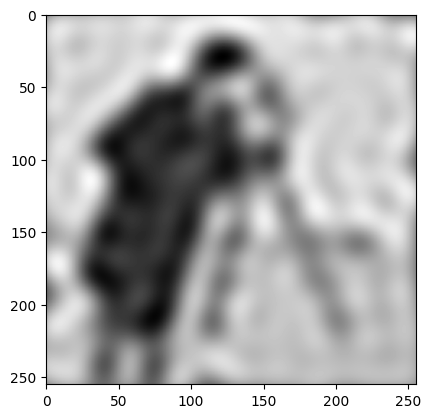

Convergence not reached


In [8]:
fitted_image, G = rbf_fit(url, num_centers, rbf_function, rbf_gradient_function, weights_gradient_function, weights_hessian_function, scale, smoothness, penalty, subsample_size, eras, step_function, stepsize, momentum, inertia, tol)

In [9]:
url = "http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/implicita/output_9_0.png"
num_centers = 500
scale = 5e-3
smoothness = 0.01
penalty = 1
subsample_size = 3000
eras = 100
stepsize = 1e-3
momentum = 0.9
inertia = 0.8
tol = 1e-5
weights_gradient_function = weightsGradientRidge
weights_hessian_function = weightsHessianRidge
step_function = NAG
rbf_function = multiquad_rbf
rbf_gradient_function = rbf_gradient_multiquad

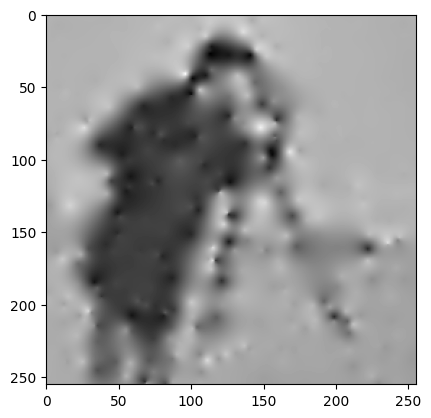

Convergence not reached


In [10]:
fitted_image, G = rbf_fit(url, num_centers, rbf_function, rbf_gradient_function, weights_gradient_function, weights_hessian_function, scale, smoothness, penalty, subsample_size, eras, step_function, stepsize, momentum, inertia, tol)

In [11]:
url = "http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/implicita/output_9_0.png"
num_centers = 300
scale = 3e-3
smoothness = 0.01
penalty = 1
subsample_size = 3000
eras = 100
stepsize = 1e-2
momentum = 0.9
inertia = 0.8
tol = 1e-5
weights_gradient_function = weightsGradientRidge
weights_hessian_function = weightsHessianRidge
step_function = GD
rbf_function = gaussian_rbf
rbf_gradient_function = rbf_gradient_gaussian

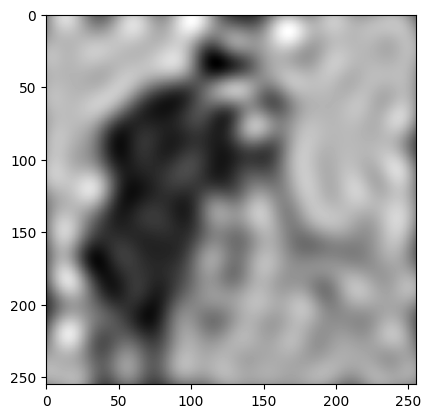

Convergence not reached


In [12]:
fitted_image, G = rbf_fit(url, num_centers, rbf_function, rbf_gradient_function, weights_gradient_function, weights_hessian_function, scale, smoothness, penalty, subsample_size, eras, step_function, stepsize, momentum, inertia, tol)

In [13]:
url = "http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/implicita/output_9_0.png"
num_centers = 300
scale = 5e-3
smoothness = 0.01
penalty = 1
subsample_size = 3000
eras = 100
stepsize = 1e-2
momentum = 0.9
inertia = 0.8
tol = 1e-5
weights_gradient_function = weightsGradientRidge
weights_hessian_function = weightsHessianRidge
step_function = GD
rbf_function = multiquad_rbf
rbf_gradient_function = rbf_gradient_multiquad

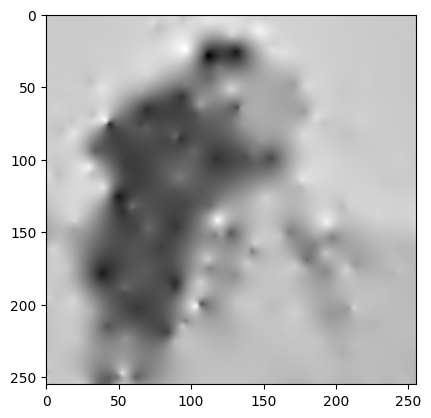

Convergence not reached


In [14]:
fitted_image, G = rbf_fit(url, num_centers, rbf_function, rbf_gradient_function, weights_gradient_function, weights_hessian_function, scale, smoothness, penalty, subsample_size, eras, step_function, stepsize, momentum, inertia, tol)

In [15]:
url = "http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/implicita/output_9_0.png"
num_centers = 100
scale = 3e-3
smoothness = 0.01
penalty = 1
subsample_size = 3000
eras = 100
stepsize = 1e-2
momentum = 0.9
inertia = 0.999
tol = 1e-9
weights_gradient_function = weightsGradientRidge
weights_hessian_function = weightsHessianRidge
step_function = ADAM
rbf_function = gaussian_rbf
rbf_gradient_function = rbf_gradient_gaussian

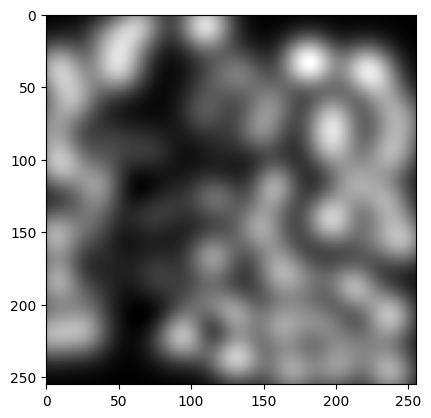

Convergence reached at iteration 9


In [16]:
fitted_image, G = rbf_fit(url, num_centers, rbf_function, rbf_gradient_function, weights_gradient_function, weights_hessian_function, scale, smoothness, penalty, subsample_size, eras, step_function, stepsize, momentum, inertia, tol)

In [17]:
url = "http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/implicita/output_9_0.png"
num_centers = 100
scale = 5e-3
smoothness = 0.01
penalty = 1
subsample_size = 3000
eras = 100
stepsize = 1e-2
momentum = 0.9
inertia = 0.8
tol = 1e-5
weights_gradient_function = weightsGradientRidge
weights_hessian_function = weightsHessianRidge
step_function = ADAM
rbf_function = multiquad_rbf
rbf_gradient_function = rbf_gradient_multiquad

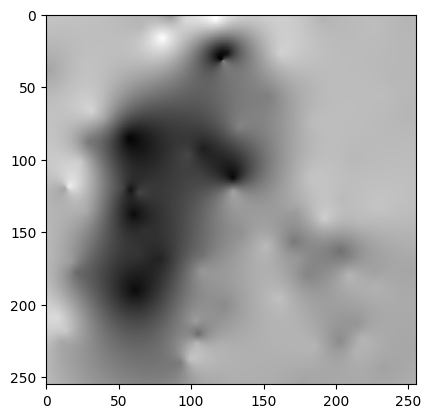

Convergence not reached


In [18]:
fitted_image, G = rbf_fit(url, num_centers, rbf_function, rbf_gradient_function, weights_gradient_function, weights_hessian_function, scale, smoothness, penalty, subsample_size, eras, step_function, stepsize, momentum, inertia, tol)